# A Proxy Peng-Robinson EOS for Efficient Modeling of Phase Behavior
#### Mark Zhao, M.S.E, 2021
#### mark.zhao@utexas.edu


#### Foreword
For more detailed explanations, please see my thesis, "A Proxy Peng-Robinson EOS for Efficient Modeling of Phase Behavior", available at The University of Texas at Austin.  

### Summary
The main novelty of this research is to present a fast and general formulation for a proxy model of fugacity coefficient based on the Peng-Robinson EOS (Peng and Robinson 1976). To this end, we develop fast and accurate artificial neural networks (ANNs) for compositional reservoir simulation, using a novel set of parameters. The predictor features are: mixed attraction parameter $A_m$, mixed covolume parameter $B_m$, component covolume parameter $B_i$ and $(\sum{x_{i}A_{ij}}{})_i$. We generate training data using the PR EOS using semi-random sampling within a T-P-x range. We train Nc number of ANN models using Tensorflow-Keras, then implement the models into a stand-alone simulator. Lastly, we optimize code with just-in-time compilation for a fair speed comparison between ANN and conventional EOS algorithms.  


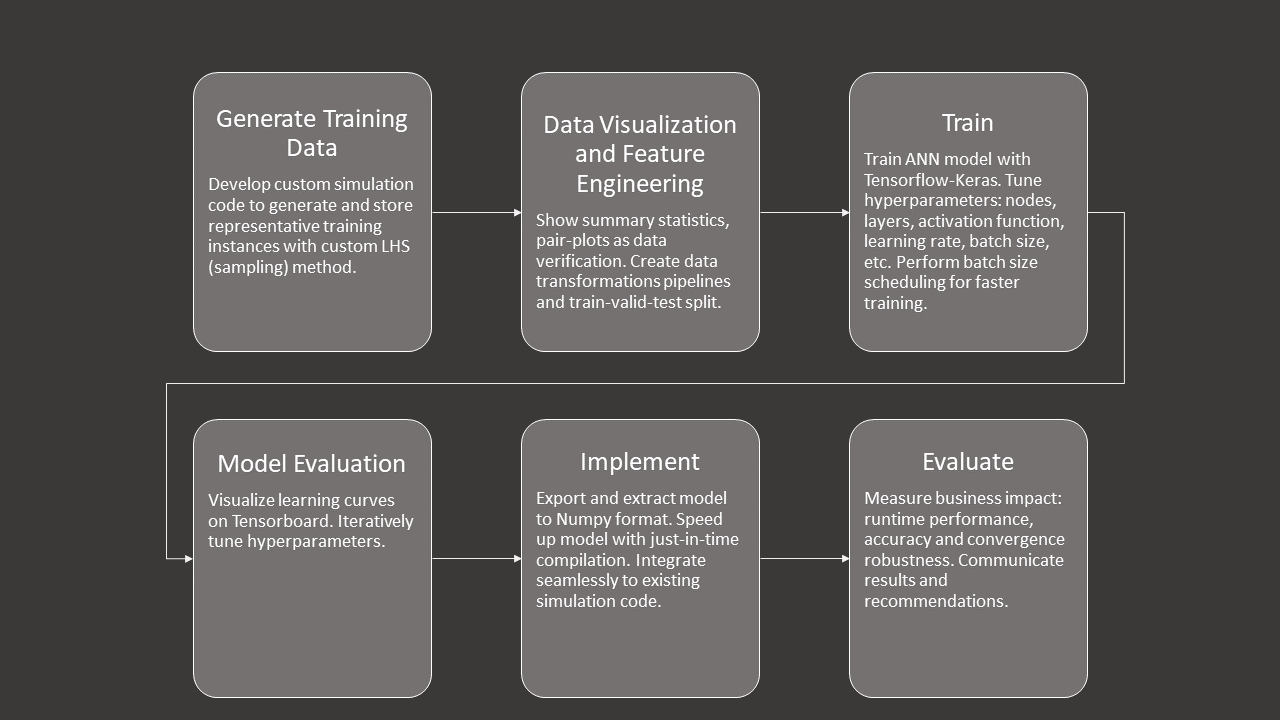

### Table of Contents
    1. Model Formulation
    2. Stability Analysis and Flash
    3. Training Data Generation
    4. ANN Training
    5. Implementation in Stand-Alone Simulator

### 1. Model Formulation
Please see Chapter 3 of the thesis for the key advantages of this formulation.  
$ln \phi_i=f_{ANN_i}(A_m, B_m, B_i, (\sum{x_{i}A_{ij}}{})_i)$

### 2. Conventional Stability Analysis and Flash
Please see Appendix A and B of the thesis for flowcharts of the code. The ANN models offer speed up because they bypass the cubic equation calculations and the evaluation of the fugacity coefficient.  

Below is a snippet of the conventional SA and Flash code. The full version can be found in the main.py.

    def two_phase_flash_iterate(self, Pr, Tr, w, SSmaxit, SStol, TolRR, Nc, Am, b_i, NRmaxit,z):
        # Wilson's Correlation for K values
        K = self.wilson_corr(Pr, Tr, w) # If remove will have local variable clash with global

        # Initial vapor phase mole fraction
        beta = 0.5

        ###################################
        # PROFILING
        # Single iteration of SS in two-phase flash.
        #for _ in range(100000):
        #    self.two_phase_flash_SS_test(Nc, K, flag, outer_loop_count, TolRR, b_i, Am, z)
        #return 'profiling', 'profiling'
        ###################################

        # Declare global var X_unprepared
        if self.useModel:
            global X_unp
            X_unp = np.empty((Nc, 4))

        # Outer loop start
        # Increment flag to break while loop.
        flag = 0
        outer_loop_count = 0

        while outer_loop_count < SSmaxit and flag < 1:  # Flag exit condition at 1 to print converged+1 x, y, K-values
            outer_loop_count += 1

            # Call NR method for beta (vapor fraction)
            beta, i_count = self.nr_beta(TolRR, K, beta, NRmaxit, z)

            # Get phase compositions from K and beta
            x = z / (1 + beta * (K - 1))
            y = K * x

            # Normalize
            x = x / np.sum(x)
            y = y / np.sum(y)

            # Check material balance for each component
            for comp in range(len(z)):
                if abs(z[comp] - (x[comp] * (1 - beta) + y[comp] * beta)) > 1E-6:# 1E-10 for EOS
                    print('Caution: Material balance problem for component ' + str(comp))
                    # debug
                    print(abs(z[comp] - (x[comp] * (1 - beta) + y[comp] * beta)))

            # Check mole fractions
            if 1 - np.sum(x) > 1E-12 or 1 - np.sum(y) > 1E-12:
                print('''Caution: Phase comp don't add up to 1.''')

            #print('Liquid comp: ' + str(x))
            #print('Vapor comp: ' + str(y))

            #####################################################
            # Liquid
            # Get parameters for Peng-Robinson EOS that are composition dependent.
            sum_xiAij = self.sum_a_interations(Nc, x, Am)
            a_mix = self.am(x, sum_xiAij)
            b_mix = self.bm(x, b_i)

            # If using ANNs, determine if the EOS has a single root. Skip this if assume single root at all conditions.
            # Otherwise, calculate the EOS roots.
            if self.useModel:
                Z = self.Z_roots_det(a_mix, b_mix)  # If multiple roots, returns array of roots. Else, returns False.
            else:
                Z = self.Z_roots_calc(a_mix, b_mix)

            # If ANNs are used, and only one root exists, use the ANNs for the fugacity coefficient.
            # Else, use conventional EOS.
            if type(Z) == bool:
                X_unp[:, :2] = a_mix, b_mix
                X_unp[:, 2:] = np.column_stack((b_i, sum_xiAij))
                ln_phi_x = ANN_numba_noargs()
            else:
                # Use EOS lnphi
                if len(Z) > 1 and min(Z) > 0:
                    print('SA: More than 1 root. Gibb\'s minimization performed.')
                    ln_phi_x, Z = self.checkG(b_i, a_mix, b_mix, sum_xiAij, Z, x)
                else:
                    ln_phi_x = self.ln_phi_calc(b_i, a_mix, b_mix, sum_xiAij, max(Z))

            ######################################################
            # Vapor
            #a_mix, b_mix = ambm(y, b_i, Am)
            sum_xiAij = self.sum_a_interations(Nc, y, Am)
            a_mix = self.am(y, sum_xiAij)
            b_mix = self.bm(y, b_i)

            if self.useModel:
                Z = self.Z_roots_det(a_mix, b_mix)  # If multiple roots, returns array of roots. Else, returns False.
            else:
                Z = self.Z_roots_calc(a_mix, b_mix)

            if type(Z) == bool:
                X_unp[:, :2] = a_mix, b_mix
                X_unp[:, 2:] = np.column_stack((b_i, sum_xiAij))
                ln_phi_y = ANN_numba_noargs()
            else:
                # Use EOS lnphi
                if len(Z) > 1 and min(Z) > 0:
                    print('SA: More than 1 root. Gibb\'s minimization performed.')
                    ln_phi_y, Z = self.checkG(b_i, a_mix, b_mix, sum_xiAij, Z, y)
                else:
                    ln_phi_y = self.ln_phi_calc(b_i, a_mix, b_mix, sum_xiAij, max(Z))

            # Converge check
            ln_phi_diff = ln_phi_x - ln_phi_y
            c = np.abs(ln_phi_diff - np.log(K))

            if np.max(c) < SStol:
                flag += 1
                #print('Exit flag:' + str(flag))

            # Update K
            #print('K old: ' + str(K))
            K = np.exp(ln_phi_diff)
            #print('K new: ' + str(K))
            #print('########################################')
        print('Flash SS iterations: {}'.format(outer_loop_count))
        # Compute d, for use in 3 phase SA.
        d = ln_phi_x + np.log(x)

        return x, y, d

### 3. Training Data Generation
Please see code in "Data Generation" folder. First, we define the range of temperature and pressure for the training set. For each set of T and P, we use latin hypercube sampling to generate compositions, with a n-dimensional simplex.

### 4. ANN Training
Please see "Train" folder.  
We use Tensorflow and scikit-learn modules.  
GPU training is not recommended, it is slower using the small ANNs of this research.  

### 5. Implementation in Stand-Alone Simulator
Please see main.py for implementation. Use keras_to_numpy.ipynb to convert the models from hd5 format to numpy arrays. Using numpy arrays instead of Tensorboard's fit method is faster.